## Seq2Seq를 활용한 간단한 Response Generator을 만들어보자
![이미지](http://suriyadeepan.github.io/img/seq2seq/seq2seq2.png)
* Python 3.5, Tensorflow 1.1, Konlpy (Mecab),Word2Vec (Gensim), matplotlib (Graph)

In [50]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import numpy as np
import sys 

print (sys.version)
print (tf.__version__)

3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
1.2.1


### seq2seq를 위한 Data 구성
* 형태소 분석기를 활용하여 명사만 추출 후 완전한 문장과 비교하여 학습

In [51]:
from konlpy.tag import Mecab
mecab = Mecab('/usr/local/lib/mecab/dic/mecab-ko-dic')

text_data = [
    '치즈 피자로 주문 되었습니다',
    '메뉴를 선택해 주세요',
    '음료는 무엇으로'
]

### 입력값의 명사를 통해 완전한 문장 생성

In [52]:
input_data = [' '.join(mecab.nouns(text_data)) for text_data in text_data]
train_data = [[x] + [y] for x,y in zip(input_data,text_data)]

char_array = []
all_char = ''
for text in train_data:
    all_char = all_char + ''.join(text)
char_array = list(set(all_char)) + ['[',']','P']
print(train_data)

[['치즈 피자 주문', '치즈 피자로 주문 되었습니다'], ['메뉴 선택', '메뉴를 선택해 주세요'], ['음료 무엇', '음료는 무엇으로']]


In [53]:
max_input_text = max(len(s[0]) for s in train_data)
max_output_text = max(len(s[1]) for s in train_data)
# enumerate 방법 사용 index : value 정렬
num_dic = {n: i for i, n in enumerate(char_array)}

dic_len = len(num_dic)

print ("Char List : " + str(num_dic))
print ("Char Size : " + str(dic_len))

Char List : {'택': 0, '엇': 15, '음': 1, '요': 2, '메': 3, '문': 7, '피': 4, '를': 16, ']': 28, '해': 5, 'P': 29, '다': 18, '선': 6, '세': 19, '자': 20, '치': 8, '료': 9, '뉴': 21, '무': 22, '으': 10, '주': 23, '로': 11, '는': 12, '습': 13, '즈': 25, '었': 24, '[': 27, '되': 14, '니': 26, ' ': 17}
Char Size : 30


### One Hot Encodeing
* '페파로니'의 정렬하여 1의 값으로 정렬 <br>
페 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] <br>
파 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] <br>
로 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] <br>
니 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] <br>

In [59]:
def make_train_data(train_data):
    input_batch = []
    output_batch = []
    target_batch = []

    for seq in train_data:
        # 인코더 셀의 입력값. 입력단어의 글자들을 한글자씩 떼어 배열로 만든다.
        input = [num_dic[n] for n in seq[0]+'P' * (max_input_text - len(seq[0]))]
        # 디코더 셀의 입력값. 시작을 나타내는 [ 심볼을 맨 앞에 붙여준다.
        output = [num_dic[n] for n in ('[' + seq[1] + 'P' * (max_output_text - len(seq[1])))]
        # 학습을 위해 비교할 디코더 셀의 출력값. 끝나는 것을 알려주기 위해 마지막에 ] 를 붙인다.
        target = [num_dic[n] for n in (seq[1] + 'P' * (max_output_text - len(seq[1])) + ']' )]
        input_batch.append(np.eye(dic_len)[input])
        output_batch.append(np.eye(dic_len)[output])
        target_batch.append(target)
    return input_batch, output_batch, target_batch
#make_train_data(train_data)

### 모델 저장을 위한 함수
* 현재폴더의 model폴더를 만들어 모델을 저장한다 
* 모델이 존재할 경우 삭제하고 새로 만든다

In [55]:
file_path = './model'
def model_file(file_path, flag):
    if(flag):
        import os
        saver = tf.train.Saver(tf.global_variables())

        if(not os.path.exists(file_path)):
            os.makedirs(file_path)
        saver.save(sess, ''.join(file_path + "/.model"))
        print("Model Saved")
    else:
        import shutil
        try:
            shutil.rmtree(file_path)
            print("Model Deleted")
        except OSError as e:
            if e.errno == 2:
                # 파일이나 디렉토리가 없음!
                print ('No such file or directory to remove')
                pass
            else:
                raise

### Tensorflow Graph 생성
* seq2seq모델의 Graph 생성
* 동일한 크기의 encoder과 decoder의 크기로 학습

In [56]:
# 옵션 설정
learning_rate = 0.01
n_hidden = 128
total_epoch = 200
# one hot 위한 사이즈
n_class = n_input = dic_len

# 그래프 초기화 
tf.reset_default_graph()
# Seq2Seq 모델은 인코더의 입력과 디코더의 입력의 형식이 같다.
enc_input = tf.placeholder(tf.float32, [None, None, n_input])
dec_input = tf.placeholder(tf.float32, [None, None, n_input])
targets = tf.placeholder(tf.int64, [None, None])

# 인코더
with tf.variable_scope("encoder"):
    enc_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)
    enc_cell = tf.contrib.rnn.DropoutWrapper(enc_cell, output_keep_prob=0.5)
    # scope.reuse_variables()
    outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input,
                                            dtype=tf.float32)

# 디코더
with tf.variable_scope("decoder"):
    dec_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden)
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=0.5)
    # Seq2Seq 모델 구현
    outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input,
                                            initial_state=enc_states,
                                            dtype=tf.float32)

model = tf.layers.dense(outputs, n_class, activation=None)

cost = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=model, labels=targets))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
input_batch, output_batch, target_batch = make_train_data(train_data)



### 학습결과 출력
* matplotlib 활용 학습 결과 출력

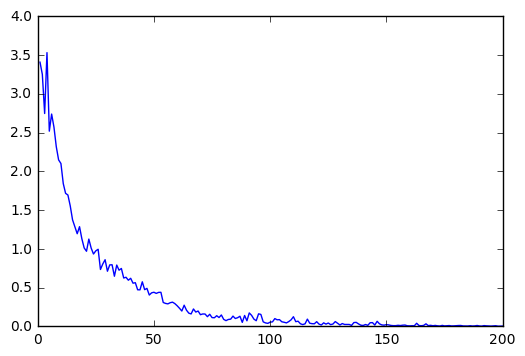

In [57]:
import matplotlib.pyplot as plt

def display_train():
    plot_X = []
    plot_Y = []
    for epoch in range(total_epoch):
        _, loss = sess.run([optimizer, cost],
                           feed_dict={enc_input: input_batch,
                                      dec_input: output_batch,
                                      targets: target_batch})
        plot_X.append(epoch + 1)
        plot_Y.append(loss)
    # Graphic display
    plt.plot(plot_X, plot_Y, label='cost')
    plt.show()

display_train()

### 예측 수행

In [58]:
# 최적화가 끝난 뒤, 변수를 저장합니다.
model_file(file_path, True)

# 단어를 입력받아 번역 단어를 예측하고 디코딩하는 함수
def predict(word):
    input_batch, output_batch, target_batch = make_train_data([word])
    # 결과가 [batch size, time step, input] 으로 나오기 때문에,
    # 2번째 차원인 input 차원을 argmax 로 취해 가장 확률이 높은 글자를 예측 값으로 만든다.
    # http://pythonkim.tistory.com/73
    prediction = tf.argmax(model, 2)
    result = sess.run(prediction,
                      feed_dict={enc_input: input_batch,
                                 dec_input: output_batch,
                                 targets: target_batch})
    # 결과 값인 숫자의 인덱스에 해당하는 글자를 가져와 글자 배열을 만든다.
    decoded = [char_array[i] for i in result[0]]
    if 'P' in decoded:
        end = decoded.index('P')
        decoded = decoded[:end]
    elif ']' in decoded:
        end = decoded.index(']')
        decoded = decoded[:end] 
    return decoded

print ("Predict : 치즈 피자 주문 -> " + ''.join(predict(['치즈 피자 주문',''])))
print ("Predict : 메뉴 선택 -> " + ''.join(predict(['메뉴 선택',''])))
print ("Predict : 음료 무엇 -> " + ''.join(predict(['음료 무엇',''])))

model_file(file_path, False)

Model Saved
Predict : 치즈 피자 주문 -> 치즈 피자로 주문  었습니다
Predict : 메뉴 선택 -> 메뉴를 선택해해주세요
Predict : 음료 무엇 -> 음료는 무엇으로
Model Deleted
